In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv("../data/zillow/City_time_series.csv")

# Display basic info
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst 2 rows:")
print(df.head(5))

Shape: (3762566, 81)

Columns: ['Date', 'RegionName', 'InventorySeasonallyAdjusted_AllHomes', 'InventoryRaw_AllHomes', 'MedianListingPricePerSqft_1Bedroom', 'MedianListingPricePerSqft_2Bedroom', 'MedianListingPricePerSqft_3Bedroom', 'MedianListingPricePerSqft_4Bedroom', 'MedianListingPricePerSqft_5BedroomOrMore', 'MedianListingPricePerSqft_AllHomes', 'MedianListingPricePerSqft_CondoCoop', 'MedianListingPricePerSqft_DuplexTriplex', 'MedianListingPricePerSqft_SingleFamilyResidence', 'MedianListingPrice_1Bedroom', 'MedianListingPrice_2Bedroom', 'MedianListingPrice_3Bedroom', 'MedianListingPrice_4Bedroom', 'MedianListingPrice_5BedroomOrMore', 'MedianListingPrice_AllHomes', 'MedianListingPrice_CondoCoop', 'MedianListingPrice_DuplexTriplex', 'MedianListingPrice_SingleFamilyResidence', 'MedianPctOfPriceReduction_AllHomes', 'MedianPctOfPriceReduction_CondoCoop', 'MedianPctOfPriceReduction_SingleFamilyResidence', 'MedianPriceCutDollar_AllHomes', 'MedianPriceCutDollar_CondoCoop', 'MedianPriceCut

In [3]:
import pandas as pd

# Load data
df = pd.read_csv("../data/zillow/City_time_series.csv")

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Basic temporal and geographic stats
print("Date range:", df['Date'].min(), "to", df['Date'].max())
print("Number of unique cities (RegionName):", df['RegionName'].nunique())
print("Total rows:", len(df))

# Check % of missing values in key target columns (e.g., ZHVI_AllHomes)
key_cols = ['ZHVI_AllHomes', 'MedianListingPrice_AllHomes', 'ZRI_AllHomes']
for col in key_cols:
    pct_missing = df[col].isna().mean() * 100
    print(f"% Missing in {col}: {pct_missing:.2f}%")

Date range: 1996-04-30 00:00:00 to 2017-12-31 00:00:00
Number of unique cities (RegionName): 16636
Total rows: 3762566
% Missing in ZHVI_AllHomes: 18.05%
% Missing in MedianListingPrice_AllHomes: 88.52%
% Missing in ZRI_AllHomes: 70.81%


In [4]:
# Keep only essential columns
df_clean = df[['Date', 'RegionName', 'ZHVI_AllHomes']].copy()

# Filter to years with better coverage (2010–2017)
df_clean = df_clean[(df_clean['Date'] >= '2010-01-01') & (df_clean['Date'] <= '2017-12-31')]

# Drop rows where ZHVI_AllHomes is NaN
df_clean = df_clean.dropna(subset=['ZHVI_AllHomes'])

# Optional: Keep only cities with at least 24 months of data (2 years)
city_counts = df_clean['RegionName'].value_counts()
cities_with_enough_data = city_counts[city_counts >= 24].index
df_clean = df_clean[df_clean['RegionName'].isin(cities_with_enough_data)]

print("Filtered shape:", df_clean.shape)
print("Date range:", df_clean['Date'].min(), "to", df_clean['Date'].max())
print("Number of cities retained:", df_clean['RegionName'].nunique())

Filtered shape: (1245588, 3)
Date range: 2010-01-31 00:00:00 to 2017-12-31 00:00:00
Number of cities retained: 13147


In [5]:
# Re-load original data or use your existing `df` (before filtering)
# If you still have `df` in memory from initial load, use it.
# Otherwise, reload:

df_original = pd.read_csv("../data/zillow/City_time_series.csv")
df_original['Date'] = pd.to_datetime(df_original['Date'])

# Check duplicates on (Date, RegionName)
dup_mask = df_original.duplicated(subset=['Date', 'RegionName'], keep=False)
num_dups = dup_mask.sum()
print(f"Duplicate (Date, RegionName) rows: {num_dups}")


Duplicate (Date, RegionName) rows: 0


In [7]:
import pandas as pd
import os

# Ensure the output directory exists
os.makedirs("../data/processed", exist_ok=True)

# ... [your existing data loading and filtering code] ...

# After creating national_monthly:
national_monthly.to_csv("../data/processed/national_zhvi_monthly.csv", index=False)

In [8]:
import pandas as pd

# Load your cleaned df_clean (from your earlier filtering)
# If not in memory, reload and reapply filters:
df = pd.read_csv("../data/zillow/City_time_series.csv")
df['Date'] = pd.to_datetime(df['Date'])
df_clean = df[['Date', 'RegionName', 'ZHVI_AllHomes']].copy()
df_clean = df_clean[
    (df_clean['Date'] >= '2010-01-01') & (df_clean['Date'] <= '2017-12-31')
].dropna(subset=['ZHVI_AllHomes'])

# Keep only cities with >=24 months (as you did)
city_counts = df_clean['RegionName'].value_counts()
cities_with_enough_data = city_counts[city_counts >= 24].index
df_clean = df_clean[df_clean['RegionName'].isin(cities_with_enough_data)]

# Aggregate to national monthly median
df_clean['Month'] = df_clean['Date'].dt.to_period('M')
national_monthly = df_clean.groupby('Month')['ZHVI_AllHomes'].median()
national_monthly = national_monthly.to_timestamp().to_frame().reset_index()
national_monthly.columns = ['ds', 'y']

# Check for missing months in full range
full_range = pd.date_range(start='2010-01-01', end='2017-12-01', freq='MS')
missing_months = full_range.difference(national_monthly['ds'])
print(f"Missing months in national ZHVI series: {len(missing_months)}")

# Optional: Save clean national series
national_monthly.to_csv("../data/processed/national_zhvi_monthly.csv", index=False)

# Show first and last few rows
print("\nFirst 3 rows:")
print(national_monthly.head(3))
print("\nLast 3 rows:")
print(national_monthly.tail(3))

Missing months in national ZHVI series: 0

First 3 rows:
          ds         y
0 2010-01-01  156300.0
1 2010-02-01  155700.0
2 2010-03-01  154100.0

Last 3 rows:
           ds         y
93 2017-10-01  173800.0
94 2017-11-01  174700.0
95 2017-12-01  175500.0


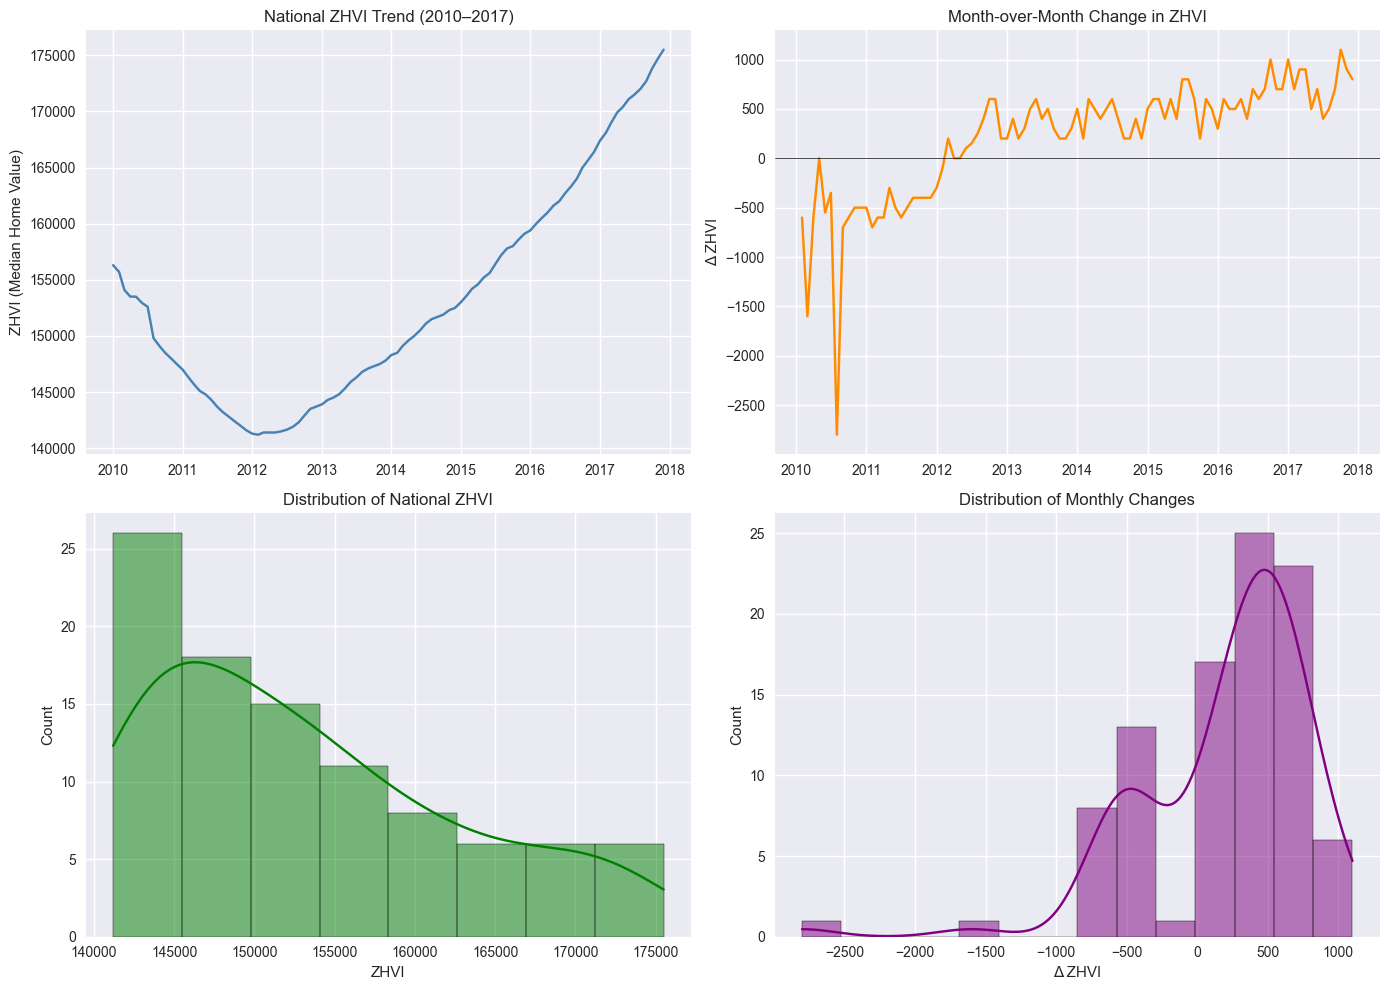

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the national series
national = pd.read_csv("../data/processed/national_zhvi_monthly.csv")
national['ds'] = pd.to_datetime(national['ds'])

# Set style
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Main trend
axes[0, 0].plot(national['ds'], national['y'], color='steelblue')
axes[0, 0].set_title('National ZHVI Trend (2010–2017)')
axes[0, 0].set_ylabel('ZHVI (Median Home Value)')
axes[0, 0].grid(True)

# 2. Monthly change (first difference)
national['y_diff'] = national['y'].diff()
axes[0, 1].plot(national['ds'][1:], national['y_diff'][1:], color='darkorange')
axes[0, 1].set_title('Month-over-Month Change in ZHVI')
axes[0, 1].set_ylabel('Δ ZHVI')
axes[0, 1].axhline(0, color='black', linewidth=0.5)
axes[0, 1].grid(True)

# 3. Distribution of ZHVI values
sns.histplot(national['y'], kde=True, ax=axes[1, 0], color='green')
axes[1, 0].set_title('Distribution of National ZHVI')
axes[1, 0].set_xlabel('ZHVI')

# 4. Distribution of monthly changes
sns.histplot(national['y_diff'].dropna(), kde=True, ax=axes[1, 1], color='purple')
axes[1, 1].set_title('Distribution of Monthly Changes')
axes[1, 1].set_xlabel('Δ ZHVI')

plt.tight_layout()
plt.savefig("../data/processed/zillow_eda_plots.png", dpi=150)
plt.show()

In [10]:
import pandas as pd
import re

# Load city data
df = pd.read_csv("../data/zillow/City_time_series.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Common 2-letter state codes (US + DC)
us_states = {
    'al', 'ak', 'az', 'ar', 'ca', 'co', 'ct', 'de', 'dc', 'fl', 'ga',
    'hi', 'id', 'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 'ma',
    'mi', 'mn', 'ms', 'mo', 'mt', 'ne', 'nv', 'nh', 'nj', 'nm', 'ny',
    'nc', 'nd', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx',
    'ut', 'vt', 'va', 'wa', 'wv', 'wi', 'wy'
}

# Function to extract state from RegionName suffix
def extract_state(region):
    # Try last 2 letters
    if len(region) >= 2:
        suffix2 = region[-2:].lower()
        if suffix2 in us_states:
            return suffix2.upper()
    # Try last 3 if ends with common patterns (e.g., 'cal', but rare)
    return None

# Apply
df['State'] = df['RegionName'].apply(extract_state)

# Check how many rows got a state
print("Rows with inferred state:", df['State'].notna().sum())
print("Coverage: {:.2f}%".format(df['State'].notna().mean() * 100))
print("\nTop inferred states:")
print(df['State'].value_counts().head(10))

Rows with inferred state: 3762566
Coverage: 100.00%

Top inferred states:
State
PA    370800
NY    264563
CA    202308
OH    180261
TX    171272
IL    163389
MI    160939
NJ    153113
FL    151218
WI    136014
Name: count, dtype: int64


In [12]:
# Aggregate to state-monthly median
state_monthly = df_filtered.groupby(['State', df_filtered['Date'].dt.to_period('M')])['ZHVI_AllHomes'].median()

# Reset index to turn MultiIndex into columns
state_monthly = state_monthly.reset_index()

# Now convert the 'Date' (which is a Period) to timestamp
state_monthly['Date'] = state_monthly['Date'].dt.to_timestamp()

# Rename columns to Prophet-friendly format
state_monthly = state_monthly.rename(columns={'Date': 'ds', 'ZHVI_AllHomes': 'y'})

# Save
state_monthly.to_csv("../data/processed/state_zhvi_monthly.csv", index=False)

print("Final state-level dataset shape:", state_monthly.shape)
print("\nRows per state:")
print(state_monthly['State'].value_counts().sort_index())

Final state-level dataset shape: (288, 3)

Rows per state:
State
CA    96
FL    96
TX    96
Name: count, dtype: int64


In [13]:
import pandas as pd

# Load the processed data
df_regions = pd.read_csv("../data/processed/state_zhvi_monthly.csv")
df_regions['ds'] = pd.to_datetime(df_regions['ds'])
df_regions = df_regions.sort_values(['State', 'ds']).reset_index(drop=True)

# Show first 10 rows (early 2010)
print("First 10 rows (Start of time series - 2010):")
print(df_regions.head(10))
print("\n" + "="*50 + "\n")

# Show last 10 rows (end of 2017)
print("Last 10 rows (End of time series - 2017):")
print(df_regions.tail(10))

First 10 rows (Start of time series - 2010):
  State         ds         y
0    CA 2010-01-01  307800.0
1    CA 2010-02-01  305400.0
2    CA 2010-03-01  303800.0
3    CA 2010-04-01  301300.0
4    CA 2010-05-01  300300.0
5    CA 2010-06-01  301500.0
6    CA 2010-07-01  302600.0
7    CA 2010-08-01  300100.0
8    CA 2010-09-01  298100.0
9    CA 2010-10-01  295900.0


Last 10 rows (End of time series - 2017):
    State         ds         y
278    TX 2017-03-01  148550.0
279    TX 2017-04-01  149450.0
280    TX 2017-05-01  150150.0
281    TX 2017-06-01  151300.0
282    TX 2017-07-01  152750.0
283    TX 2017-08-01  153850.0
284    TX 2017-09-01  154300.0
285    TX 2017-10-01  154800.0
286    TX 2017-11-01  154350.0
287    TX 2017-12-01  154500.0


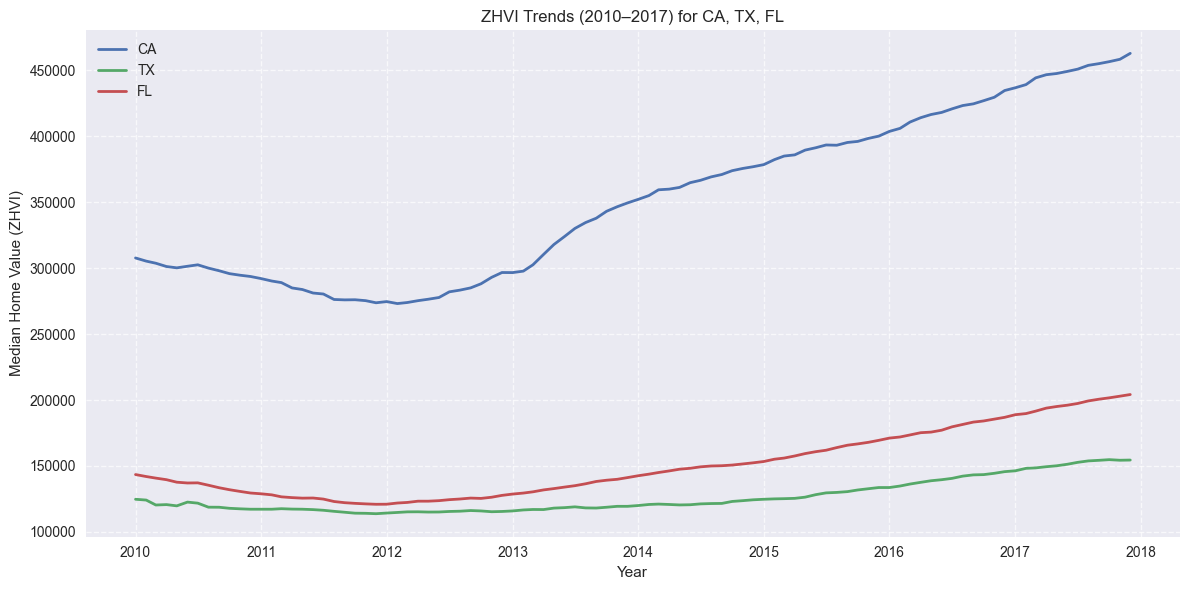

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../data/processed/state_zhvi_monthly.csv")
df['ds'] = pd.to_datetime(df['ds'])

plt.figure(figsize=(12, 6))
for state in ['CA', 'TX', 'FL']:
    state_data = df[df['State'] == state]
    plt.plot(state_data['ds'], state_data['y'], label=state, linewidth=2)

plt.title('ZHVI Trends (2010–2017) for CA, TX, FL')
plt.xlabel('Year')
plt.ylabel('Median Home Value (ZHVI)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("../data/processed/regional_zhvi_trends.png", dpi=150)
plt.show()

In [15]:
%pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [16]:
import pandas as pd
from prophet import Prophet
import os

# Load your state-level data
df = pd.read_csv("../data/processed/state_zhvi_monthly.csv")
df['ds'] = pd.to_datetime(df['ds'])

# Ensure output dir
os.makedirs("../data/forecasts", exist_ok=True)

# Target states
states = ['CA', 'TX', 'FL']
forecast_horizon = 12  # Forecast 12 months into 2018

all_forecasts = []

for state in states:
    print(f"\nTraining Prophet model for {state}...")
    
    # Filter data for this state
    state_data = df[df['State'] == state][['ds', 'y']].copy()
    
    # Initialize and fit Prophet
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,  # Monthly data → no weekly pattern
        daily_seasonality=False,
        seasonality_mode='multiplicative'  # Better for growing trends
    )
    model.fit(state_data)
    
    # Create future dataframe
    future = model.make_future_dataframe(periods=forecast_horizon, freq='MS')  # MS = Month Start
    
    # Forecast
    forecast = model.predict(future)
    forecast['State'] = state
    
    # Save forecast
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'State']].to_csv(
        f"../data/forecasts/forecast_{state}.csv", index=False
    )
    
    all_forecasts.append(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'State']])
    
    # Optional: Plot forecast
    fig = model.plot(forecast)
    fig.suptitle(f'ZHVI Forecast for {state} (2010–2018)')
    plt.savefig(f"../data/forecasts/forecast_plot_{state}.png", dpi=150, bbox_inches='tight')
    plt.close()

# Combine all forecasts
combined_forecast = pd.concat(all_forecasts, ignore_index=True)
combined_forecast.to_csv("../data/forecasts/combined_forecasts.csv", index=False)

print("\n✅ All models trained! Forecasts saved in ../data/forecasts/")

d:\shri\RealtyAI\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.



Training Prophet model for CA...


17:56:49 - cmdstanpy - INFO - Chain [1] start processing
17:56:52 - cmdstanpy - INFO - Chain [1] done processing
17:56:52 - cmdstanpy - INFO - Chain [1] start processing



Training Prophet model for TX...


17:56:53 - cmdstanpy - INFO - Chain [1] done processing
17:56:54 - cmdstanpy - INFO - Chain [1] start processing



Training Prophet model for FL...


17:56:55 - cmdstanpy - INFO - Chain [1] done processing



✅ All models trained! Forecasts saved in ../data/forecasts/


In [17]:
import pandas as pd

# Load one forecast (e.g., CA)
forecast_ca = pd.read_csv("../data/forecasts/forecast_CA.csv")
print("CA Forecast (last 5 rows of history + first 5 of 2018):")
print(forecast_ca.tail(10))  # Should include Dec 2017 + Jan–May 2018

CA Forecast (last 5 rows of history + first 5 of 2018):
             ds           yhat     yhat_lower     yhat_upper State
98   2018-03-01  473405.607458  471421.808393  475153.888136    CA
99   2018-04-01  474837.504971  472502.700527  476958.700665    CA
100  2018-05-01  477646.033560  474558.202857  480389.443544    CA
101  2018-06-01  480423.285979  476551.331115  483819.679690    CA
102  2018-07-01  483574.266363  478718.692159  487804.374674    CA
103  2018-08-01  484389.982516  478794.579219  489664.329794    CA
104  2018-09-01  486319.465836  479769.739027  492797.705143    CA
105  2018-10-01  488547.586253  480973.915402  496244.667268    CA
106  2018-11-01  491266.466800  482330.743901  500189.229556    CA
107  2018-12-01  493949.598428  483544.409031  504210.879562    CA


In [19]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np
import pandas as pd

results = []

for state in ['CA', 'TX', 'FL']:
    # Load original historical data for this state
    hist_full = df[df['State'] == state][['ds', 'y']].copy()
    hist_full['ds'] = pd.to_datetime(hist_full['ds'])
    hist_full = hist_full.set_index('ds')
    
    # Load full forecast (which includes history + future)
    fcst_full = pd.read_csv(f"../data/forecasts/forecast_{state}.csv")
    fcst_full['ds'] = pd.to_datetime(fcst_full['ds'])
    fcst_full = fcst_full.set_index('ds')
    
    # Get intersection of dates (should be 2010-01 to 2017-12)
    common_dates = hist_full.index.intersection(fcst_full.index)
    
    if len(common_dates) == 0:
        print(f"⚠️ No overlapping dates for {state}. Skipping evaluation.")
        continue
        
    y_true = hist_full.loc[common_dates, 'y']
    y_pred = fcst_full.loc[common_dates, 'yhat']
    
    # Remove any NaNs
    valid = ~(y_true.isna() | y_pred.isna())
    y_true = y_true[valid]
    y_pred = y_pred[valid]
    
    if len(y_true) == 0:
        print(f"⚠️ No valid data for {state}.")
        continue
    
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    results.append({'State': state, 'MAPE (%)': round(mape, 2), 'RMSE': round(rmse, 2)})

eval_df = pd.DataFrame(results)
print("\n✅ Model Evaluation (Historical Fit):")
print(eval_df)


✅ Model Evaluation (Historical Fit):
  State  MAPE (%)     RMSE
0    CA      0.24  1096.94
1    TX      0.36   599.25
2    FL      0.15   288.99


In [20]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

results = []

for state in ['CA', 'TX', 'FL']:
    # Load historical data
    hist_full = df[df['State'] == state][['ds', 'y']].copy()
    hist_full['ds'] = pd.to_datetime(hist_full['ds'])
    hist_full = hist_full.set_index('ds')
    
    # Load full forecast (includes history + future)
    fcst_full = pd.read_csv(f"../data/forecasts/forecast_{state}.csv")
    fcst_full['ds'] = pd.to_datetime(fcst_full['ds'])
    fcst_full = fcst_full.set_index('ds')
    
    # Align on common dates (2010–2017)
    common_dates = hist_full.index.intersection(fcst_full.index)
    
    if len(common_dates) == 0:
        print(f"⚠️ No overlapping dates for {state}. Skipping.")
        continue
        
    y_true = hist_full.loc[common_dates, 'y']
    y_pred = fcst_full.loc[common_dates, 'yhat']
    
    # Remove NaNs
    valid = ~(y_true.isna() | y_pred.isna())
    y_true = y_true[valid]
    y_pred = y_pred[valid]
    
    if len(y_true) == 0:
        print(f"⚠️ No valid data for {state}.")
        continue
    
    # Metrics
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    results.append({
        'State': state,
        'MAPE (%)': round(mape, 2),
        'RMSE': round(rmse, 2),
        'R²': round(r2, 4)
    })

eval_df = pd.DataFrame(results)
print("\n✅ Model Evaluation (2010–2017 Historical Fit):")
print(eval_df)



✅ Model Evaluation (2010–2017 Historical Fit):
  State  MAPE (%)     RMSE      R²
0    CA      0.24  1096.94  0.9997
1    TX      0.36   599.25  0.9977
2    FL      0.15   288.99  0.9999


In [21]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import numpy as np

# Load your state-level data
df = pd.read_csv("../data/processed/state_zhvi_monthly.csv")
df['ds'] = pd.to_datetime(df['ds'])

test_results = []

for state in ['CA', 'TX', 'FL']:
    print(f"\nTesting {state} with 2017 holdout...")
    
    # Get full data for state
    state_data = df[df['State'] == state][['ds', 'y']].copy()
    
    # Split: train = 2010–2016, test = 2017
    train = state_data[state_data['ds'] < '2017-01-01']
    test = state_data[(state_data['ds'] >= '2017-01-01') & (state_data['ds'] <= '2017-12-31')]
    
    if len(train) == 0 or len(test) == 0:
        print(f"⚠️ Insufficient data for {state}")
        continue
    
    # Train Prophet on 2010–2016
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='multiplicative'
    )
    model.fit(train)
    
    # Forecast 12 months (2017)
    future = model.make_future_dataframe(periods=12, freq='MS')
    forecast = model.predict(future)
    
    # Merge forecast with actual test values
    test_forecast = forecast[forecast['ds'].isin(test['ds'])]
    test_merged = pd.merge(test, test_forecast[['ds', 'yhat']], on='ds', how='inner')
    
    if len(test_merged) == 0:
        print(f"⚠️ No overlap for {state}")
        continue
    
    y_true = test_merged['y']
    y_pred = test_merged['yhat']
    
    # Metrics on **2017 only**
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    test_results.append({
        'State': state,
        'Test Period': '2017',
        'MAPE (%)': round(mape, 2),
        'RMSE': round(rmse, 2),
        'R²': round(r2, 4)
    })

# Show results
test_df = pd.DataFrame(test_results)
print("\n✅ OUT-OF-SAMPLE TEST RESULTS (2017 Holdout):")
print(test_df)

18:06:49 - cmdstanpy - INFO - Chain [1] start processing



Testing CA with 2017 holdout...


18:06:50 - cmdstanpy - INFO - Chain [1] done processing
18:06:51 - cmdstanpy - INFO - Chain [1] start processing



Testing TX with 2017 holdout...


18:06:52 - cmdstanpy - INFO - Chain [1] done processing
18:06:52 - cmdstanpy - INFO - Chain [1] start processing



Testing FL with 2017 holdout...


18:06:53 - cmdstanpy - INFO - Chain [1] done processing



✅ OUT-OF-SAMPLE TEST RESULTS (2017 Holdout):
  State Test Period  MAPE (%)     RMSE      R²
0    CA        2017      0.48  2707.25  0.8672
1    TX        2017      0.45  1066.63  0.8564
2    FL        2017      0.32   763.11  0.9758


In [23]:
import os

# Create the results directory if it doesn't exist
os.makedirs("../results", exist_ok=True)

# Now save the file
test_df.to_csv("../results/forecast_evaluation_2017_holdout.csv", index=False)

In [25]:
import os
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Ensure output directories exist
os.makedirs("../results", exist_ok=True)

# Load your state-level data (must have 'State', 'ds', 'y')
df = pd.read_csv("../data/processed/state_zhvi_monthly.csv")
df['ds'] = pd.to_datetime(df['ds'])

# Initialize results list
test_results = []

# Loop over each state
for state in ['CA', 'TX', 'FL']:
    print(f"\nTesting {state} with 2017 holdout...")
    
    # Filter data for this state
    state_data = df[df['State'] == state][['ds', 'y']].copy()
    
    # Split: train = 2010–2016, test = 2017
    train = state_data[state_data['ds'] < '2017-01-01']
    test = state_data[(state_data['ds'] >= '2017-01-01') & (state_data['ds'] <= '2017-12-31')]
    
    if len(train) == 0 or len(test) == 0:
        print(f"⚠️ Insufficient data for {state}")
        continue
    
    # Train Prophet model
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='multiplicative'
    )
    model.fit(train)
    
    # Forecast 12 months (2017)
    future = model.make_future_dataframe(periods=12, freq='MS')
    forecast = model.predict(future)
    
    # Merge actual test values with forecasted values
    test_forecast = forecast[forecast['ds'].isin(test['ds'])]
    test_merged = pd.merge(test, test_forecast[['ds', 'yhat']], on='ds', how='inner')
    
    if len(test_merged) == 0:
        print(f"⚠️ No forecast overlap for {state}")
        continue
    
    # Compute metrics
    y_true = test_merged['y']
    y_pred = test_merged['yhat']
    
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    test_results.append({
        'State': state,
        'Test Period': '2017',
        'MAPE (%)': round(mape, 2),
        'RMSE': round(rmse, 2),
        'R²': round(r2, 4)
    })
    
    # Plot actual vs forecast for 2017
    plt.figure(figsize=(10, 5))
    plt.plot(test_merged['ds'], test_merged['y'], 'o-', label='Actual 2017', linewidth=2)
    plt.plot(test_merged['ds'], test_merged['yhat'], 's--', label='Forecast 2017', linewidth=2)
    plt.title(f'{state} ZHVI: Actual vs Forecast (2017)', fontsize=14)
    plt.ylabel('ZHVI (Home Value Index)')
    plt.xlabel('Month')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"../results/forecast_vs_actual_{state}.png", dpi=150)
    plt.close()

# Save evaluation results
test_df = pd.DataFrame(test_results)
test_df.to_csv("../results/forecast_evaluation_2017_holdout.csv", index=False)

print("\n✅ OUT-OF-SAMPLE TEST RESULTS (2017 Holdout):")
print(test_df)

18:19:39 - cmdstanpy - INFO - Chain [1] start processing



Testing CA with 2017 holdout...


18:19:40 - cmdstanpy - INFO - Chain [1] done processing
18:19:40 - cmdstanpy - INFO - Chain [1] start processing



Testing TX with 2017 holdout...


18:19:41 - cmdstanpy - INFO - Chain [1] done processing
18:19:42 - cmdstanpy - INFO - Chain [1] start processing



Testing FL with 2017 holdout...


18:19:43 - cmdstanpy - INFO - Chain [1] done processing



✅ OUT-OF-SAMPLE TEST RESULTS (2017 Holdout):
  State Test Period  MAPE (%)     RMSE      R²
0    CA        2017      0.48  2707.25  0.8672
1    TX        2017      0.45  1066.63  0.8564
2    FL        2017      0.32   763.11  0.9758


In [26]:
import os
from prophet.serialize import model_to_json

# Create models directory if it doesn't exist
os.makedirs("../models", exist_ok=True)

# Inside your loop over states (CA, TX, FL)
for state in ['CA', 'TX', 'FL']:
    # ... [your existing code to prepare `train` data] ...
    
    # Train the model
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='multiplicative'
    )
    model.fit(train)
    
    # ✅ Save the model as JSON
    model_path = f"../models/prophet_model_{state}.json"
    with open(model_path, "w") as fout:
        fout.write(model_to_json(model))
    
    print(f"✅ Model for {state} saved to {model_path}")

18:27:45 - cmdstanpy - INFO - Chain [1] start processing
18:27:48 - cmdstanpy - INFO - Chain [1] done processing
18:27:48 - cmdstanpy - INFO - Chain [1] start processing


✅ Model for CA saved to ../models/prophet_model_CA.json


18:27:49 - cmdstanpy - INFO - Chain [1] done processing
18:27:49 - cmdstanpy - INFO - Chain [1] start processing


✅ Model for TX saved to ../models/prophet_model_TX.json


18:27:51 - cmdstanpy - INFO - Chain [1] done processing


✅ Model for FL saved to ../models/prophet_model_FL.json


In [27]:
import os
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Ensure results directory exists
os.makedirs("../results", exist_ok=True)

# Load your state-level data
df = pd.read_csv("../data/processed/state_zhvi_monthly.csv")
df['ds'] = pd.to_datetime(df['ds'])

# Loop over each state to generate forecast vs actual for 2017
for state in ['CA', 'TX', 'FL']:
    print(f"Generating test comparison plot for {state}...")
    
    # Get full data for the state
    state_data = df[df['State'] == state][['ds', 'y']].copy()
    
    # Split: train on 2010–2016, test on 2017
    train = state_data[state_data['ds'] < '2017-01-01']
    test = state_data[(state_data['ds'] >= '2017-01-01') & (state_data['ds'] <= '2017-12-31')]
    
    if len(train) == 0 or len(test) == 0:
        print(f"⚠️ Skipping {state}: insufficient data.")
        continue
    
    # Train Prophet model
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='multiplicative'
    )
    model.fit(train)
    
    # Forecast 2017 (12 months)
    future = model.make_future_dataframe(periods=12, freq='MS')
    forecast = model.predict(future)
    
    # Extract 2017 forecast
    forecast_2017 = forecast[forecast['ds'].dt.year == 2017][['ds', 'yhat']]
    
    # Merge with actual 2017 values
    plot_data = pd.merge(test, forecast_2017, on='ds', how='inner')
    
    if plot_data.empty:
        print(f"⚠️ No overlap for {state}.")
        continue
    
    # --- Plot ---
    plt.figure(figsize=(10, 5))
    plt.plot(plot_data['ds'], plot_data['y'], 'o-', color='steelblue', label='Actual (2017)', linewidth=2, markersize=6)
    plt.plot(plot_data['ds'], plot_data['yhat'], 's--', color='crimson', label='Forecast (2017)', linewidth=2, markersize=5)
    
    plt.title(f'{state} Home Value Trend: Actual vs Forecast (2017)', fontsize=14, fontweight='bold')
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('ZHVI (Median Home Value)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    # Save plot
    plt.savefig(f"../results/test_comparison_{state}.png", dpi=150)
    plt.close()

print("\n✅ All test comparison plots saved to ../results/")

18:31:16 - cmdstanpy - INFO - Chain [1] start processing


Generating test comparison plot for CA...


18:31:17 - cmdstanpy - INFO - Chain [1] done processing
18:31:17 - cmdstanpy - INFO - Chain [1] start processing


Generating test comparison plot for TX...


18:31:18 - cmdstanpy - INFO - Chain [1] done processing
18:31:19 - cmdstanpy - INFO - Chain [1] start processing


Generating test comparison plot for FL...


18:31:20 - cmdstanpy - INFO - Chain [1] done processing



✅ All test comparison plots saved to ../results/
